In [ ]:
import qiskit
import math
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator

In [ ]:
# Below is code for representing a Bayesian network. Note that this program only works for networks with two-state nodes.

# The network is a directed, acyclic graph.

class network:
    def __init__(self, root_nodes, child_nodes):
        # Root nodes is a list of probabilities of the root nodes/events occurring independently.
        self.root_nodes = root_nodes
        # Child nodes is a list of lists of: tuples of list indices representing the parent nodes; a tuple of probabilities for each combination of
        # occurences of the parent nodes. The order of the probabilities counts up in binary from 0 to 2^n, where n is the number of parent nodes.
        self.child_nodes = child_nodes

    def find_child_probs(self): #exact inference for classical bayes inference
        # Finds the probability of each child node occurring and returns them as a list.
        child_probs = [0]*len(self.child_nodes)
        children_found = [False]*len(self.child_nodes)
        root_num = len(self.root_nodes)
        def find_prob(node, node_index):
            # Finds the probability for a single child node.
            parent_probs = []
            for index in node[0]:
                # Find the parent node for the given index
                prob = None
                # Check if root or child node
                if index < root_num:
                    # Root node
                    prob = self.root_nodes[index]
                else:
                    # Child node
                    if children_found[index-root_num]:
                        prob = child_probs[index-root_num]
                    else:
                        prob = find_prob(self.child_nodes[index - root_num], index)

                assert prob != None
                parent_probs.append(prob)
            node_prob = 0
            for n, cond_prob in enumerate(node[1]):
                binary = bin(n)[2:].zfill(len(parent_probs))
                p = cond_prob
                for i, b in enumerate(binary):
                    if b == '1':
                        p *= parent_probs[i]
                    elif b == '0':
                        p *= 1 - parent_probs[i]
                node_prob += p

            children_found[node_index] = True
            return node_prob

        for child_index, child in enumerate(self.child_nodes):
            if not children_found[child_index]:
                child_probs[child_index] = find_prob(child, child_index)

        return child_probs

    # Translates the network to a corresponding quantum circuit, draws it, and calculates the child probabilities.

    def quantum_circuit(self, draw=True):

        # Defines a quantum circuit with qubits and classical bits for measurement.
        # The number of classical bits equals the number of child nodes,
        # since we only need to measure the outcomes of child nodes.
        qc = qiskit.QuantumCircuit(len(self.root_nodes) + len(self.child_nodes), len(self.child_nodes))

        # Determine the number of root nodes.
        root_num = len(self.root_nodes)

        # Iterate over each root node to apply the appropriate quantum gates.
        for r, root in enumerate(self.root_nodes):
            if root == 1:
                # If the root node's probability is 1, apply the X gate to set it to |1>.
                qc.x(r)
            else:
                # If the root node's probability is less than 1, apply the RY gate with the calculated angle.
                # The angle is determined using the formula derived from the probabilities. (eq 13 in paper)
                qc.ry(2*math.atan(math.sqrt(root/(1-root))), r)

        # Iterate over each child node to define their relationships with parent nodes.
        for c, child in enumerate(self.child_nodes):
            # For each combination of parent node states, represented by binary numbers.
            for b, prob in enumerate(child[1]):
                # Convert the index to a binary string, padded with zeros to match the number of parent nodes.
                binary = bin(b)[2:].zfill(len(child[0]))

                # Prepare the qubits for the current combination of parent states.
                for i, n in enumerate(binary):
                    if n == '0':
                        # Apply the X gate to the qubit corresponding to the parent node if its state is 0.
                        qc.x(child[0][i])

                # Check the probability associated with the current combination of parent states.
                if prob == 1:
                    # If the probability is 1, apply the multi-controlled X gate (MCX) to set the child node to |1>.
                    qc.mcx(list(child[0]), c+root_num)

                else:
                    # If the probability is less than 1, apply the multi-controlled RY gate (MCRY).
                    # The angle for the rotation is derived from the probability. (eq 14 from paper)
                    qc.mcry(2*math.atan(math.sqrt(prob/(1-prob))), list(child[0]), c+root_num)

                # Reset the qubits back to their original state before the next iteration.
                for i, n in enumerate(binary):
                        if n == '0':
                            qc.x(child[0][i])

                # Insert a barrier to prevent any unintended interactions between gates.
                qc.barrier()

        # Measure the output of each child node's qubit and store it in the corresponding classical bit.
        for c in range(len(self.child_nodes)):
            qc.measure(c+root_num, c)
        if draw:
            display(qc.draw('mpl'))  # Use 'mpl' for better visual output


        simulator = AerSimulator()  # Directly using AerSimulator
        # Execute the circuit
        job = simulator.run(qc, shots=256)  # Run the circuit
        result = job.result()  # Get the result
        # Get counts
        results = result.get_counts(qc)

        #sim = qiskit.execute(qc, qiskit.BasicAer.get_backend('qasm_simulator'), shots=256)
        #results = sim.result().get_counts()

        # Initialize a list to hold the counts of '1's for each child node.
        node_counts = [0]*len(self.child_nodes)
        total_counts = 0

        # Iterate through the results to count occurrences of each measurement outcome.
        for result in results:
            total_counts += int(results[result])  # Sum up total measurements.
            for i, b in enumerate(result):
                if b == '1':
                    node_counts[i] += results[result]  # Increment count for '1' outcomes.

        # Normalize the counts by dividing by the total number of measurements.
        node_counts = list(map(lambda c: c / total_counts, node_counts))
        # Reverse the list to match the order of child nodes.
        node_counts.reverse()

        # Return the normalized counts of outcomes for each child node.
        return node_counts

    def visualize_results(self, node_counts, child_names):
        """
        Visualizes the results with custom child names.

        Parameters:
            node_counts (list): A list of normalized probabilities for the child nodes.
            child_names (list): A list of custom names for the child nodes.
        """
        # Check that the number of child names matches the number of node counts
        if len(child_names) != len(node_counts):
            raise ValueError("The number of child names must match the number of node counts.")

        # Create a bar chart to visualize the results
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(node_counts)), node_counts, tick_label=child_names)
        plt.xlabel('Child Nodes')
        plt.ylabel('Normalized Probability')
        plt.title('Normalized Probabilities of Child Nodes')
        plt.ylim(0, 1)
        plt.axhline(y=0, color='k', linewidth=0.8)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_bayesian_network(bn, root_names, child_names):
    """
    Visualizes the given Bayesian network with custom root and child names.

    Parameters:
        bn (network): An instance of the network class containing root nodes and child nodes.
        root_names (list): A list of names for the root nodes.
        child_names (list): A list of names for the child nodes.
    """
    root_nodes = bn.root_nodes
    child_nodes = bn.child_nodes

    # Check that the provided root and child names match the expected lengths
    if len(root_names) != len(root_nodes):
        raise ValueError("The number of root names must match the number of root nodes.")
    if len(child_names) != len(child_nodes):
        raise ValueError("The number of child names must match the number of child nodes.")

    # Create a directed graph
    G = nx.DiGraph()

    # Add root nodes with custom names
    for i, root_name in enumerate(root_names):
        G.add_node(root_name)

    # Add child nodes with custom names and their parent connections
    for i, (parents, probs) in enumerate(child_nodes):
        child_node_label = child_names[i]
        G.add_node(child_node_label, label=child_node_label)
        for parent in parents:
            if parent < len(root_nodes):
                parent_label = root_names[parent]
            else:
                parent_label = child_names[parent - len(root_nodes)]
            G.add_edge(parent_label, child_node_label)

    # Create a larger figure
    plt.figure(figsize=(12, 8))  # size

    # Use circular layout to avoid overlapping
    pos = nx.circular_layout(G)

    # Draw the graph with adjusted node and edge sizes
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=2500, node_color='lightblue',
            font_size=10, font_weight='bold', width=1.5)
    node_labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels=node_labels)

    # Show the plot
    plt.title("Bayesian Network Visualization")
    plt.show()


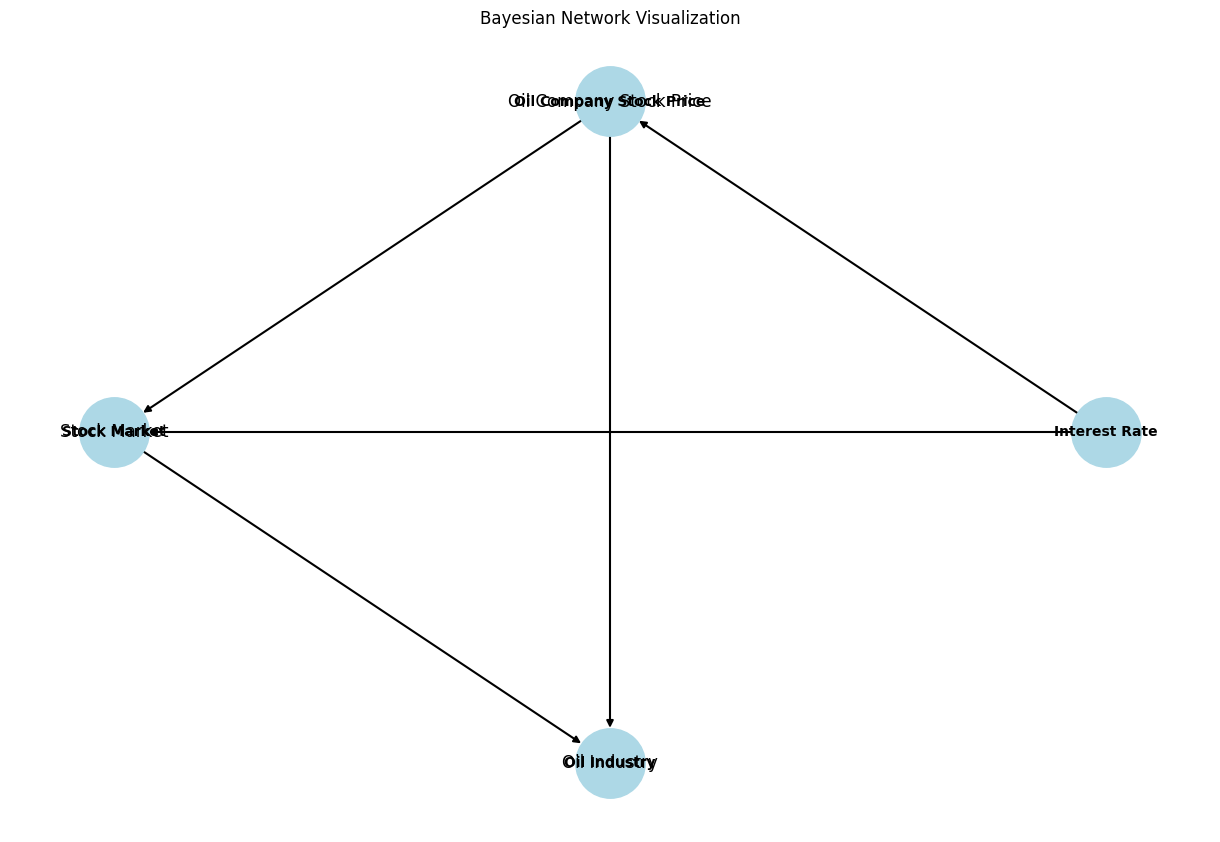

In [ ]:
# Example usage
# Create an instance of the network class
#oil stock prediction
bn1 = network(
    # Root node: Interest Rate
    [0.212],  # Interest Rate with probability 0.788 for 0, 0.212 for 1

    # Child nodes with parent dependencies and conditional probabilities
    [
        # Oil Company Stock Price depends on Interest Rate
        [(0,), (0.5786802, 1)],  # Conditional probabilities for Oil Company Stock Price

        # Stock Market depends on both Interest Rate and Oil Company Stock Price
        [(0,1), (0.31686747, 0.11052632, 0.5 , 0.94716981)],  # Conditional probabilities for Stock Market

        # Oil Industry depends on Oil Company Stock Price and Stock Market
        [(1,2), (0.6366843, 1, 0.89539347, 1)]  # Conditional probabilities for Oil Industry
    ]
)

visualize_bayesian_network(bn1,['Interest Rate'],['Oil Company Stock Price','Stock Market','Oil Industry'])


Classical Inference: [0.6679999976, 0.3104032864340724, 0.8686332224570379]


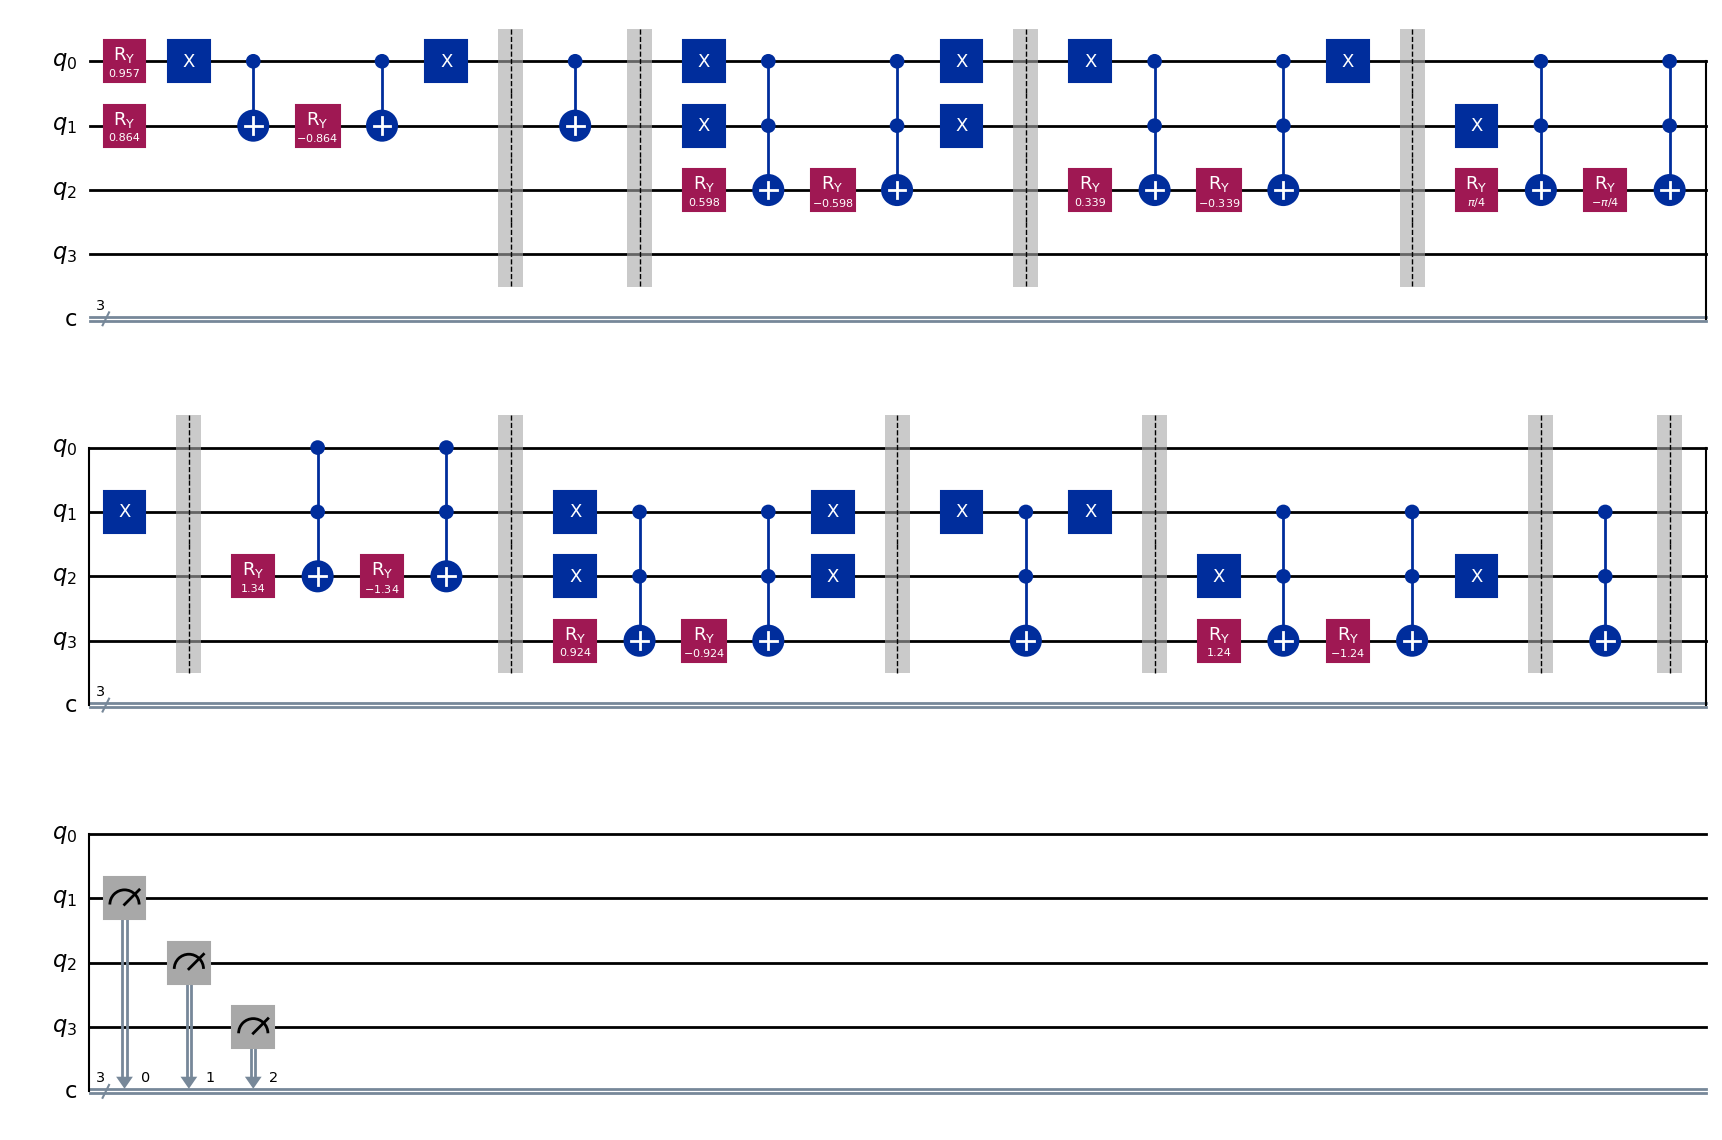

[0.71875, 0.37109375, 0.859375]

In [ ]:
print("Classical Inference:",bn1.find_child_probs())
bn1.quantum_circuit()


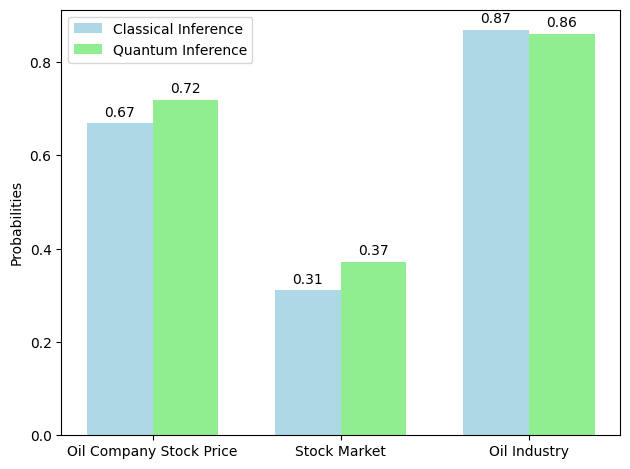

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['Oil Company Stock Price','Stock Market','Oil Industry']
classical_probs = [0.6679999976, 0.3104032864340724, 0.8686332224570379]
quantum_probs = [0.71875, 0.37109375, 0.859375]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Create bar plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, classical_probs, width, label='Classical Inference', color='lightblue')
bars2 = ax.bar(x + width/2, quantum_probs, width, label='Quantum Inference', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probabilities')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding value labels on top of the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.show()


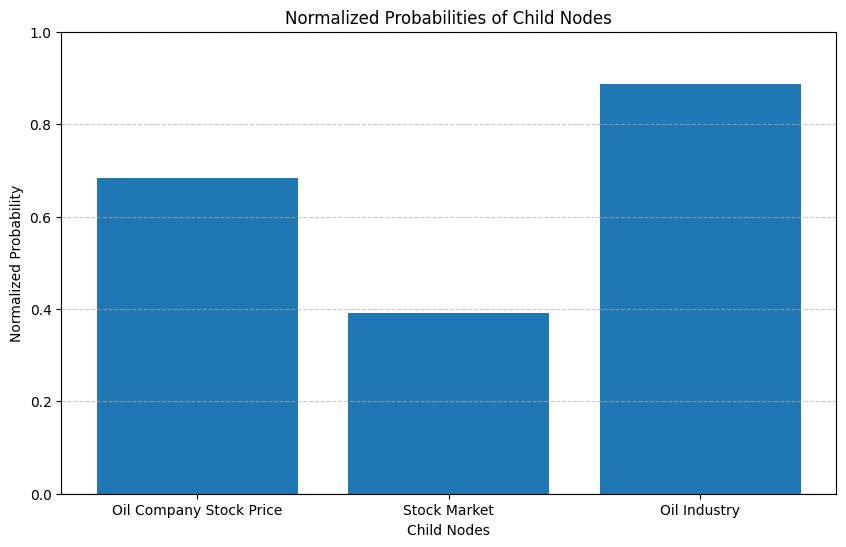

In [ ]:
normalized_counts = bn1.quantum_circuit(draw=False)

# Visualize the results
bn1.visualize_results(normalized_counts, ['Oil Company Stock Price', 'Stock Market', 'Oil Industry'])

Classical (Actual): 0.6679999976
95% CI: (0.6659562606928918, 0.6698015518071082)
Mean: 0.66787890625
Standard Deviation: 0.03096758889370705
Percent Error: 0.00018127447669909324



/var/folders/6q/5vy060nd70n18078bjnxwpjr0000gn/T/ipykernel_2192/1841213329.py:16: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  print("95% CI: " + str(st.t.interval(alpha=0.95, df=len(avg)-1, loc=np.mean(avg), scale=st.sem(avg))))


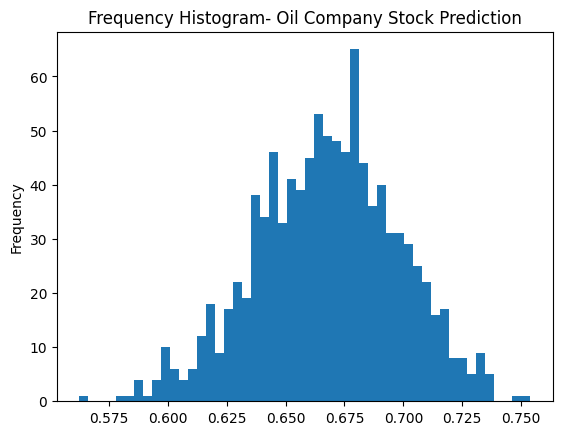

In [ ]:

# Accuracy and Precision
num = 1000
#bnl = [bn1, bn2, bn3, bn4, bn5]
bnl = [bn1]
for bn in bnl:
    classical = bn.find_child_probs()[0]
    avg = []
    for k in range(0,num):
        #res = bn.quantum_circuit(False)
        #if any(isinstance(p, list) for p in res):
        avg.append(bn.quantum_circuit(False)[0])
    #if any(isinstance(p, list) for p in avg): iter = len(avg)
    mean = sum(avg) / len(avg)
    stdev = np.std(avg)
    print("Classical (Actual): " + str(classical))
    print("95% CI: " + str(st.t.interval(alpha=0.95, df=len(avg)-1, loc=np.mean(avg), scale=st.sem(avg))))
    print("Mean: " + str(mean))
    print("Standard Deviation: " + str(stdev))
    print("Percent Error: " + str(np.abs((mean-classical)/classical))+ "\n")
    plt.hist(avg, bins=50)
    plt.gca().set(title='Frequency Histogram- Oil Company Stock Prediction', ylabel='Frequency')

In [ ]:
#Shots: Controls the accuracy of the quantum circuit result in a single execution.
#num: Allows you to measure how consistent the results are across multiple executions of the quantum circuit.


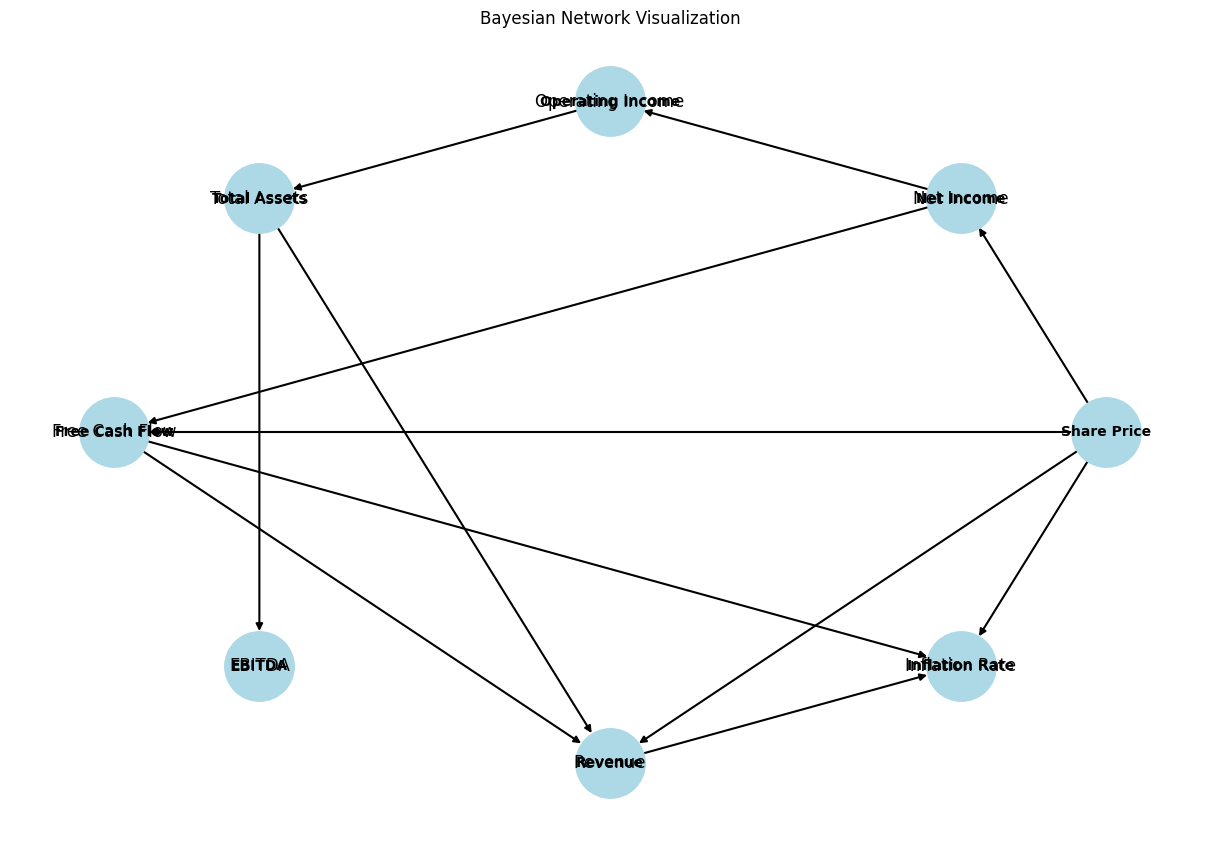

In [ ]:
# Initialize root nodes and child nodes
root_nodes1 = [
    0.2796  # Share Price (USD)
]

child_nodes1 = []

# Net Income (USD) has 1 parent node (index: Share Price = 0)
child_nodes1.append(([0], [
    0.0001, 1
]))

# Operating Income (USD) has 1 parent node (index: Net Income = 1)
child_nodes1.append(([1], [
    0.0345, 0.8007
]))

# Total Assets (USD) has 1 parent node (index: Operating Income = 2)
child_nodes1.append(([2], [
    0.0001, 1
]))

# Free Cash Flow (USD) has 2 parent nodes (indices: Net Income = 1, Share Price = 0)
child_nodes1.append(([0, 1], [
    0.3133,0.5893, 1,1
]))


# EBITDA (USD) has 1 parent node (index: Total Assets = 3)
child_nodes1.append(([3], [
    0.0001, 1
]))

# Revenue (USD) has 3 parent nodes (indices: Free Cash Flow = 4, Share Price = 0, Total Assets = 3)
child_nodes1.append(([0, 3, 4], [
    0.475, 1, 0.0001, 0.001, 0.5, 0.5,1, 1
]))

# Inflation Rate (%) has 3 parent nodes (indices: Free Cash Flow = 4, Revenue = 6, Share Price = 0)
child_nodes1.append(([0, 4, 6], [
    0.0001, 0.5, 1.0, 1.0, 1, 1.0, 1.0, 1.0
]))


bn2= network(root_nodes1, child_nodes1)
visualize_bayesian_network(bn2, ['Share Price'], ['Net Income', 'Operating Income', 'Total Assets', 'Free Cash Flow', 'EBITDA', 'Revenue', 'Inflation Rate'])

Classical Inference: [0.27967204, 0.248784717048, 0.2488598385762952, 0.560908623582016, 0.24893495259243759, 0.5910795013327313, 0.7771770632949891]


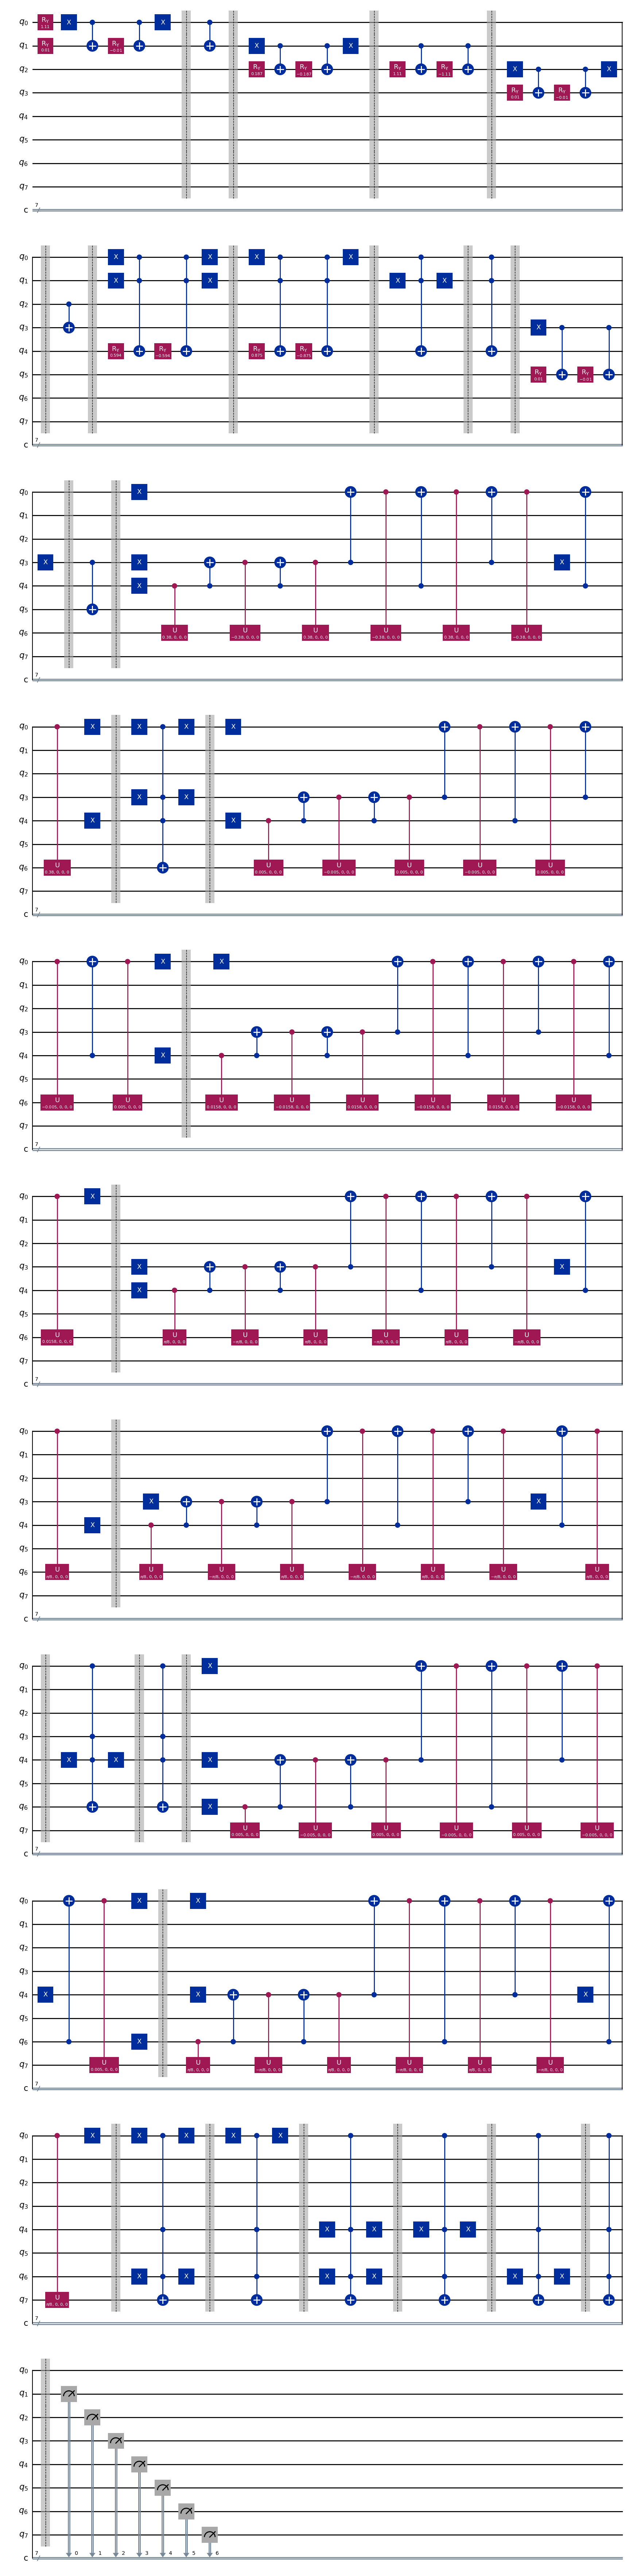

[0.33203125, 0.2890625, 0.2890625, 0.5546875, 0.2890625, 0.7109375, 0.63671875]

In [ ]:
print("Classical Inference:",bn2.find_child_probs())
bn2.quantum_circuit()

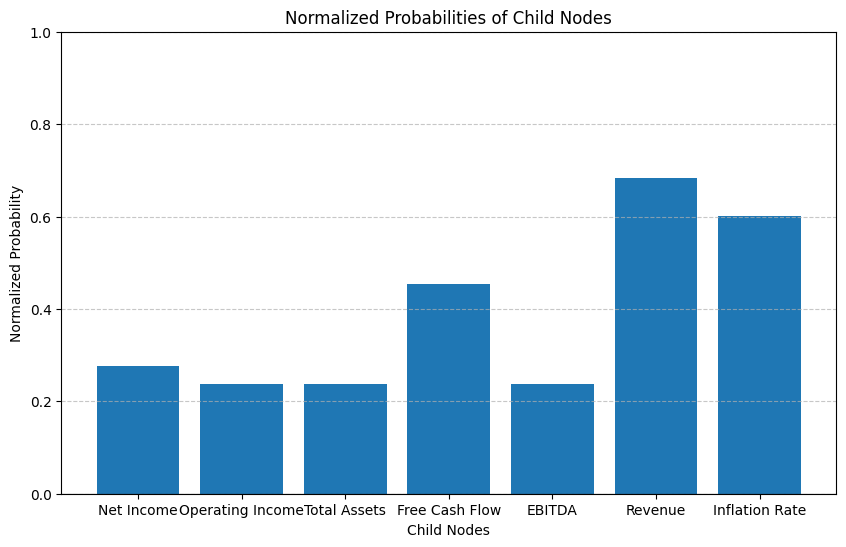

In [ ]:
normalized_counts = bn2.quantum_circuit(draw=False)

# Visualize the results
bn2.visualize_results(normalized_counts, ['Net Income', 'Operating Income', 'Total Assets', 'Free Cash Flow', 'EBITDA', 'Revenue', 'Inflation Rate'])

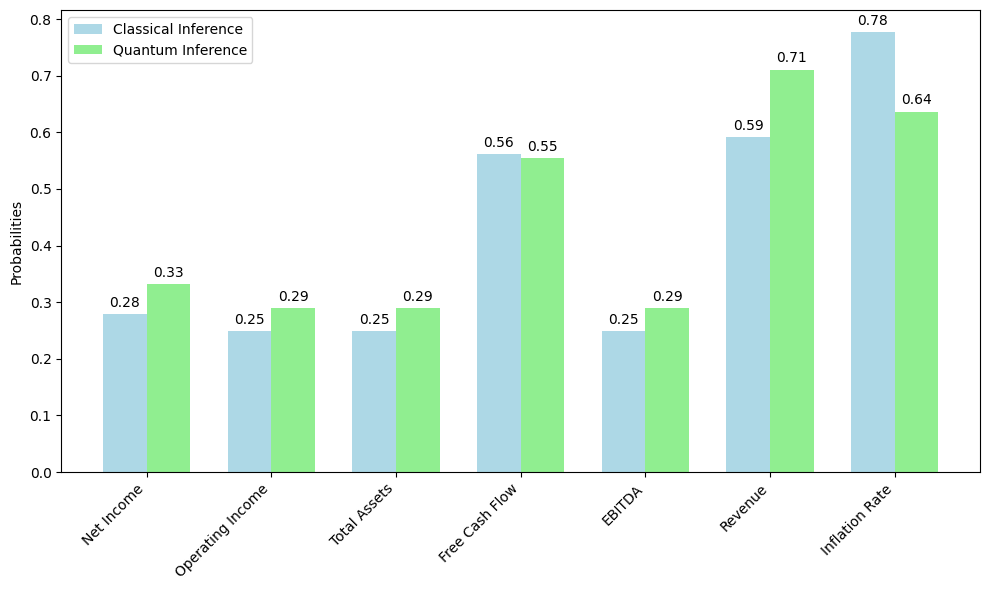

In [ ]:
# Data for the 7 nodes
labels = ['Net Income', 'Operating Income', 'Total Assets', 'Free Cash Flow', 'EBITDA', 'Revenue', 'Inflation Rate']
classical_probs = [0.27967204, 0.248784717048, 0.2488598385762952, 0.560908623582016, 0.24893495259243759, 0.5910795013327313, 0.7771770632949891]
quantum_probs = [0.33203125, 0.2890625, 0.2890625, 0.5546875, 0.2890625, 0.7109375, 0.63671875]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, classical_probs, width, label='Classical Inference', color='lightblue')
bars2 = ax.bar(x + width/2, quantum_probs, width, label='Quantum Inference', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probabilities')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adding value labels on top of the bars
add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.show()


Classical (Actual): 0.27967204
95% CI: (0.2783477514814572, 0.28167568601854287)
Mean: 0.28001171875
Standard Deviation: 0.026801120005875426
Percent Error: 0.0012145609907948482



/var/folders/6q/5vy060nd70n18078bjnxwpjr0000gn/T/ipykernel_23816/3161810969.py:15: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  print("95% CI: " + str(st.t.interval(alpha=0.95, df=len(avg)-1, loc=np.mean(avg), scale=st.sem(avg))))


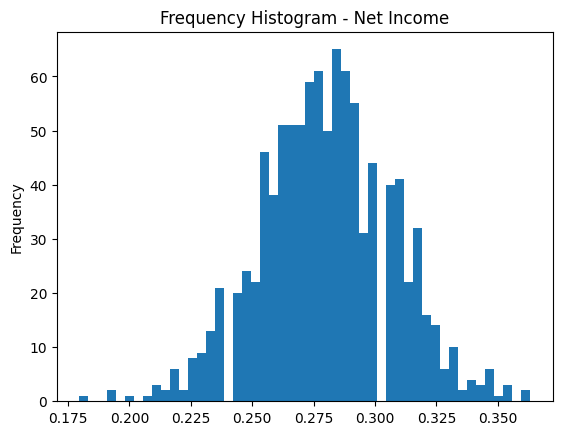

In [ ]:

# Accuracy and Precision
num = 1000
bnl = [bn2]
for bn in bnl:
    classical = bn.find_child_probs()[0]
    avg = []
    for k in range(0,num):
        #res = bn.quantum_circuit(False)
        #if any(isinstance(p, list) for p in res):
        avg.append(bn.quantum_circuit(False)[0])
    #if any(isinstance(p, list) for p in avg): iter = len(avg)
    mean = sum(avg) / len(avg)
    stdev = np.std(avg)
    print("Classical (Actual): " + str(classical))
    print("95% CI: " + str(st.t.interval(alpha=0.95, df=len(avg)-1, loc=np.mean(avg), scale=st.sem(avg))))
    print("Mean: " + str(mean))
    print("Standard Deviation: " + str(stdev))
    print("Percent Error: " + str(np.abs((mean-classical)/classical))+ "\n")
    plt.hist(avg, bins=50)
    plt.gca().set(title='Frequency Histogram - Net Income', ylabel='Frequency')